# Testing for Significant Edges

For the next two sections, we will turn back to an example we came across back when we discussed the [Signal Subnetwork model](#link?). If you recall, we had $100$ networks, which were either earthlings or astronauts. The networks each had $5$ nodes, which represented different lobes of the brain. The occipital lobe is responsible for sight, the temporal lobe with emotions and language, the parietal with hearing, the frontal with thinking and movement, and the insula with basic survivability skills. The astronauts were forced to live for several hundred thousand years on a planet in which their eyesight was challenged, and over time, evolution selected the astronauts who had a higher probability of connections between the occipital lobe and other areas of the brain. Our question of interest was as follows: if we are shown a network, how do we decide whether that network is from an earthling or an astronaut? Can we come up with a signal subnetwork classifier?

To begin to address this question, we came up with the signal subnetwork model. What we established wit hthe signal subnetwork model was that all of the edges in each network could be broken up into one of two groups: either the signal edges or the non-signal edges. We collected these signal edges into a set called the "signal subnetwork", which was a parameter for the signal subnetwork model. For these signal edges, the probability of an edge existing (or not) was different for two (or more) classes in our problem. What this means is that, in our problem above, the edges which had a node in the occipital lobe had a different connection probability for the astronauts than the humans. On the other hand, the non-signal edges did not have a different connection probability for the astronauts than the humans. 

To start this section off, let's first sample some example networks from the signal subnetwork model. Let's assume that we have a total of $100$ people, each of whom are either astronauts (with probability $\pi_{ast} = 0.4$) or humans (with probability $\pi_{earth} = 0.6$). First, we'll roll our 2-sided die $100$ times, where side 1 (class 1) corresponds to astronauts, and side 2 (class 2) corresponds to humans. We will then create the class assignment vector $\vec y$ using the number of times the die lands on each class:

In [1]:
import numpy as np

pi_ast = 0.4
pi_hum = 0.6
M = 100

# roll a 2-sided die 100 times, with probability 0.4 of landing on side 1 (astronaut) 
# and 0.6 of landing on side 2 (earthling)
np.random.seed(1234)
classnames = ["Astronaut", "Earthling"]
class_counts = np.random.multinomial(M, pvals=[pi_ast, pi_hum])
print("Number of individuals who are astronauts: {:d}".format(class_counts[0]))
print("Number of individuals who are humans: {:d}".format(class_counts[1]))

# create class assignment vector, and randomly reshuffle class labels for each individual
yvec = np.array([1 for i in range(0, class_counts[0])] + [2 for i in range(0, class_counts[1])])
np.random.seed(1234)
np.random.shuffle(yvec)

Number of individuals who are astronauts: 39
Number of individuals who are humans: 61


Next, we construct the probability matrices for each class. The probabilities for edges in which a node is in the occipital lobe are higher for the astronauts than the humans:

In [2]:
# the number of nodes
n = 5
# edge probabilities for humans are random
P_hum = np.random.beta(size=n*n, a=3, b=8).reshape(n, n)
# networks are undirected, so make the probability matrix symmetric
P_hum = (P_hum + P_hum.T)/2
# networks are loopless, so remove the diagonal
P_hum = P_hum - np.diag(np.diag(P_hum))

# the names of each of the five nodes
nodenames = ["Occipital", "Frontal", "Temporal", "Frontal", "Insula"]
# the signal edges
E = np.array([[0,1,1,1,1], [1,0,0,0,0], [1,0,0,0,0], [1,0,0,0,0], [1,0,0,0,0]], dtype=bool)
P_ast = np.copy(P_hum)

# probabilities for signal edges are higher in astronauts than humans
# square root function biases them towards 1, which is higher than
# whatever they are right now since they are between 0 and 1
P_ast[E] = np.sqrt(P_ast[E])

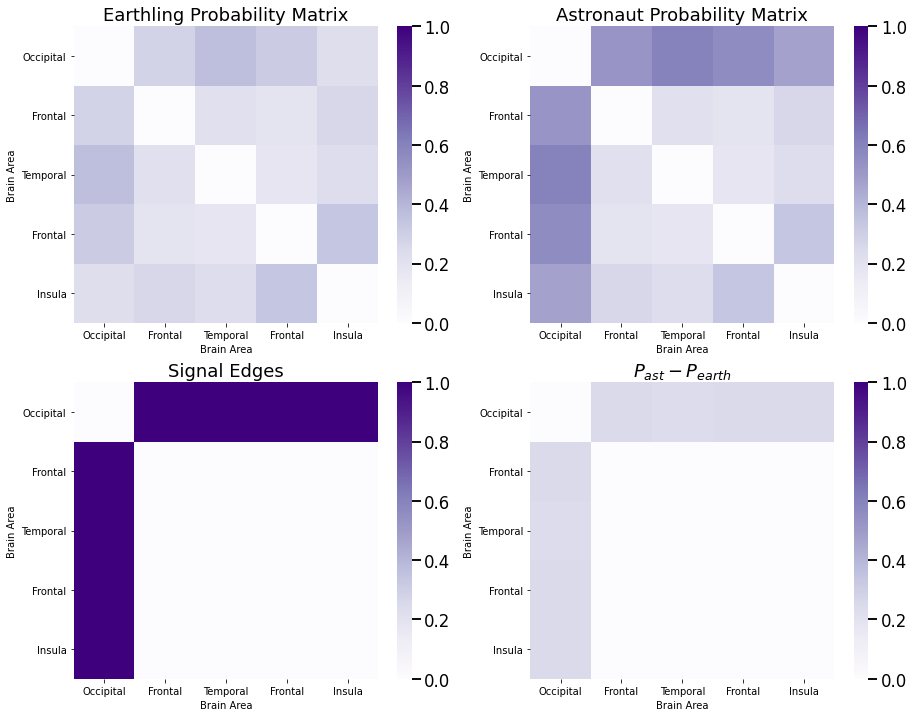

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_prob(X, title="", nodename="Brain Area", nodetix=[0.5, 1.5, 2.5, 3.5, 4.5],
             nodelabs=nodenames, ax=None, vmin=0, vmax=1):
    if (ax is None):
        fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=vmin, vmax=vmax, annot=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=nodename)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
            ax.set_xticks(nodetix)
            ax.set_xticklabels(nodelabs)
        cbar.ax.set_frame_on(True)
    return

fig, axs = plt.subplots(2,2, figsize=(15, 12))
plot_prob(P_hum, title="Earthling Probability Matrix", ax=axs[0,0])
plot_prob(P_ast, title="Astronaut Probability Matrix", ax=axs[0,1])
plot_prob(E, title="Signal Edges", ax=axs[1,0])
plot_prob(P_ast - P_hum, title="$P_{ast} - P_{earth}$", ax=axs[1,1])

Finally, we use the class assignment vector $\vec y$ to sample individual networks for each of the individuals. We plot an adjacency matrix for the first individual:

In [4]:
from graphbook_code import ier

# arrange the probability matrices in a list
prob_mtxs = [P_ast, P_hum]
# initialize empty list for adjacency matrices
As = []
np.random.seed(1234)
for y in yvec:
    # sample adjacency matrix for an individual of class y using the probability
    # matrix for that class
    As.append(ier(prob_mtxs[y - 1], directed=False, loops=False))

# stack the adjacency matrices for each individual such that node i is first dimension,
# node j is second dimension, and the individual index m is the third dimension
As = np.stack(As, axis=2)

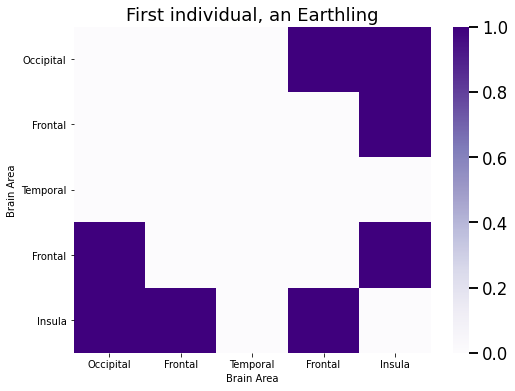

In [5]:
from graspologic.plot import heatmap

fig, ax = plt.subplots(1,1, figsize=(8, 6));
plot_prob(As[:,:,0], title="First individual, an {}".format(classnames[yvec[0] - 1]), ax=ax);


The key ideas we want to capture in our classifier are as follows:
1. We want to *only* look at the edges which have a differing connection probability amongst our classes. This means that we only want to look at *signal edges* which are in the *signal subnetwork*, and we want to ignore edges which are not in the signal subnetwork. Edges which are not in the signal subnetwork are simply noise, since they have the same connection probability between the classes, and therefore are not useful for differentiating between the different classes.
2. We want to incorporate the structure of the network into the classifier. This means we want to use the fact that nodes are nodes, and that edges are connections between nodes, to determine how to classify networks as earthling or astronaut.

To begin, we will start by addressing aim 1. We need to find which edges are in the signal subnetework. Stated another way, we need to *estimate* the signal subnetwork. What this requires is a way to identify which edges will best capture the difference between the classes in our network. Do we know anything which can do this? As it turns out, we can use Fisher's exact test, something we learned about in the section on [testing for differences between groups of edges](http://docs.neurodata.io/graph-stats-book/applications/ch8/testing-differences.html#two-sample-hypothesis-testing-with-coins), to identify the signal subnetwork. In the next section on [identifying significant vertices](#link?), we will address the second point on using the structure of the network to further refine these potential signal edges.

## Fisher's Exact Test for Edge Importance

If you remember back to the coin flip example, our setting was as follows. We had two coins, coin $1$ and coin $2$, and we wanted to test whether their probabilities of landing on heads were different. Our hypotheses were $H_A: p_1 \neq p_2$, against the null hypothesis that $H_0: p_1 = p_2$. We therefore had two random samples, the outcomes of ten coin flips from coin one and the outcomes of ten coin flips from coin two, meaning that our test of $H_A$ against $H_0$ fell into the *two-sample testing* regime. To address this, what we used was Fisher's exact test, where we counted the number of times each coin landed on heads and tails, which we aggregated in a table:

| | First coin | Second coin |
|---|---|---|
| Landed on heads | 7 | 1 |
| Landed on tails | 3 | 9 |

As it turns out, we can adapt this test for our situation here too! For a single edge, what we want to do is test whether $H_A: p_{ij}^{(ast)} \neq p_{ij}^{(earth)}$, against the null hypothesis that $H_0: p_{ij}^{(ast)} = p_{ij}^{(earth)}$. The key property of Fisher's exact test that makes this desirable for us is that, when $H_0$ is true (and the probabilities are equal), the Fisher's exact test statistic is smaller, whereas when $H_A$ is true (and the probabilities are not equal), the Fisher's exact test statistic is bigger. We will exploit this feature in our design of a classifier for astronauts versus earthlings. Note that we are using the Fisher's exact test statistic, and *not* the $p$-value of the test, for this step like we did previously when testing for differences between groups of edges. For each edge $(i, j)$, we will construct the following table:

| | Astronauts | Earthlings |
| --- | --- | --- |
| Edge $(i,j)$ exists | Number of astronauts with $(i,j)$ | Number of earthlings with edge $(i,j)$ |
| Edge $(i,j)$ does not exist | Number of astronauts with edge $(i,j)$ | Number of earthlings without edge $(i,j)$ |

Which we can do in python as follows, for the edge from the occipital lobe to the temporal lobe:

In [6]:
i = 1; j = 2  # (1,2) corresponds to the edge from occipital to temporal lobe

ast_edge = As[i-1,j-1,yvec == 1].sum()  # count the number of astronauts with edge i,j
hum_edge = As[i-1,j-1,yvec == 2].sum()  # count the number of earthlings with edge i,j
ast_noedge = class_counts[1 - 1] - ast_edge  # count the number of astronauts without edge i,j
hum_noedge = class_counts[2 - 1] - hum_edge  # count the number of earthlings without edge i,j

edge_tab = np.array([[ast_edge, hum_edge], [ast_noedge, hum_noedge]])  # arrange as in table shown above

print(edge_tab)

[[18. 12.]
 [21. 49.]]


Next, we compute the Fisher's exact test statistic on the data, using scipy:

In [8]:
from scipy.stats import fisher_exact

test_statistic, pval = fisher_exact(edge_tab)
print("p-value: {:.4f}".format(pval))

p-value: 0.0071


Note that since the edge $(i,j)$ that we chose above corresponded to the edge between the occipital and temporal lobe, we expect this edge to indicate a disparity between the astronauts and the earthlings. Why is this? Well, quite simply, by construction, this edge is a *signal* edge, which means that it carries real *signal* in differentiating a network from a human from a network of an alien. Why is this a big deal?

Well, let's see what happens if we were to compute this for a non-signal edge. Let's arbitrarily choose the edge between the temporal and frontal lobes, which corresponds to $i=3$ (the temporal lobe) and $j = 2$ (the frontal lobe):

In [9]:
i = 3; j = 2  # (3,2) corresponds to the edge from temporal to frontal lobe

ast_edge = As[i-1,j-1,yvec == 1].sum()  # count the number of astronauts with edge i,j
hum_edge = As[i-1,j-1,yvec == 2].sum()  # count the number of earthlings with edge i,j
ast_noedge = class_counts[1 - 1] - ast_edge  # count the number of astronauts without edge i,j
hum_noedge = class_counts[2 - 1] - hum_edge  # count the number of earthlings without edge i,j

edge_tab = np.array([[ast_edge, hum_edge], [ast_noedge, hum_noedge]])  # arrange as in table shown above

test_statistic, pval = fisher_exact(edge_tab)
print("p-value: {:.4f}".format(pval))

p-value: 0.8000


Well, now this test statistic happens to be a *lot* smaller than the previous one we saw, now doesn't it? Is this just by chance? The answer is: no! For signal edges, the test statistic will, by construction, *generally* be smaller than the test statistic in a non-signal edge. By *generally*, we mean that it will *tend* to be smaller (but not always!). We could certainly get samples of data where this is not the case, analogous to the idea that we could flip a fair coin (with equal probability of seeing heads and tails) 10 times and obtain all 10 flips being heads. For this reason, we will use the Fisher's exact test statistic to quantify how "important" an edge is for differentiating the two classes, or as an edge importance statistic. We will exploit this edge importance statistic as we build up our classifier further.

## Using edge importances to estimate the signal subnetwork

We will use the Fisher's exact test statistic to develop an approach which allows us to properly estimate a signal subnetwork model. The key idea is this: if we were to use any one edge of the network, we would not really be able to predict whether someone is an earthling or an alien. The reason for this is that edges either exist, or not, so unless one of the class edge probabilities for a particular edge happens to be really low (near zero) and the other happens to be really high (near one), the only informative decision boundary we could construct would be to assign one class to the networks where that particular edge exists, or the other class to the networks where that particular edge does not exist. Even less interestingly, we could abitrarily say that every network is in a particular class, which is also not going to be a particularly interesting classifier.

Another thing we could do would be to use *every* edge in the network to develop a classifier, which also isn't the best we could do. This is because if we use every edge in the classifier, w would have a lot of *noise* from the non-signal edges. This means that even though we might learn *something* from the signal edges, anything we learn is going to end up being diluted down by noise because we are including a lot of uninformative information in our classifier (the non-signal edges).

Rather, what we want to do is investigate to find the edges which are carrying all of the signal, and then isolate our downstream learning from information captured by those edges. This is because the signal edges carry all of the informative information about differentiating networks from one class to the other. This begs the question, how do we find the signal edges, and isolate them from the non-signal edges?

As we mentioned in the preceding subsection, as it happens, the Fisher's exact test statistic is going to tend to be larger for edges in which there is actual signal (the edge probability is different for astronauts and humans), and smaller when there is no signal (the edge probability is the same for astronauts and humans). That is, if an edge is in the signal subnetwork, the Fisher's exact test statistic is big, and if it is not in the signal subnetwork, the Fisher's exact test statistic is small. For this reason, what we end up doing is *rank transforming* the Fisher's exact test statistics, and then pick an arbitrary number of the highest ranking test statistics to retain for classification. 

We start by constructing a **significance matrix**, which is a collection of all of the Fisher's exact test statistics for each edge:

In [10]:
sig_mtx = np.zeros((n,n))
ast_idxs = yvec == 1  # the individuals who are astronauts
hum_idxs = yvec == 2  # the individuals who are earthlings
# since the networks are undirected, only need to compute for upper triangle
for i in range(0, n):
    for j in range(i+1, n):
        ast_edgeij = As[i,j,ast_idxs].sum()
        hum_edgeij = As[i,j,hum_idxs].sum()
        table = np.array([[ast_edgeij, hum_edgeij],
                          [class_counts[0] - ast_edgeij, class_counts[1] - hum_edgeij]])
        sig_mtx[i,j] = fisher_exact(table)[1]
sig_mtx = sig_mtx + sig_mtx.T  # symmetrize

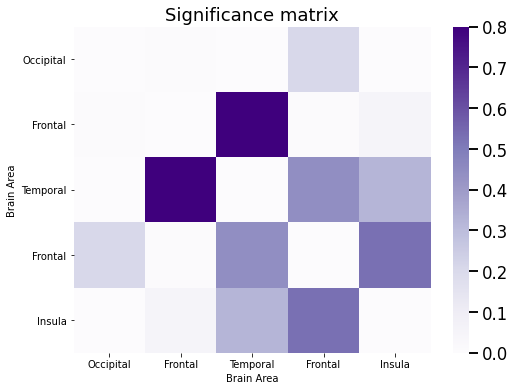

In [11]:

fig, ax = plt.subplots(1,1, figsize=(8, 6));
plot_prob(sig_mtx, title="Significance matrix", vmax=sig_mtx.max(), ax=ax)

Notice that the edges with the highest Fisher's exact test statistics in the significance matrix tend to be the edges with a node in the occipital lobe, which are our signal edges. This is great news! Next, we rank the test statistics in the significance matrix, from smallest to largest:

In [12]:
from scipy.stats import rankdata

rank_sig_mtx = rankdata(sig_mtx).reshape(n,n)

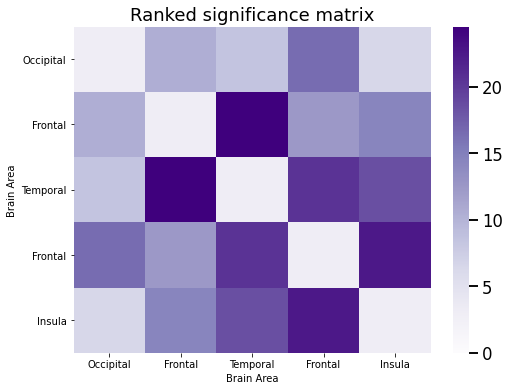

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8, 6));
plot_prob(rank_sig_mtx, title="Ranked significance matrix", vmax=rank_sig_mtx.max(), ax=ax)

And the ranks are biggest for the Fisher's exact test statistics with a node in the occipital lobe. Then, we select a number of edges (the size of the signal subnetwork) $K$, and retain the top $K$ edges, by their test statistic significances. The top $K$ edges by significance are an estimate of the signal subnetwork, $\hat{\mathcal S}$.

We can implement everything we've learned so far in graspologic relatively easily, using the `SignalSubgraph` class:

In [14]:
from graspologic.subgraph import SignalSubgraph

K = 8  # the number of edges in the subgraph
sgest = SignalSubgraph()
sgest.fit_transform(As, labels=yvec - 1, constraints=K);

Next, we arrange this into a matrix so that we can look at the signal subnetwork we identified, and compare it to the true signal subnetwork:

In [15]:
sigsub = np.zeros((n,n))  # initialize empty matrix
sigsub[sgest.sigsub_] = 1

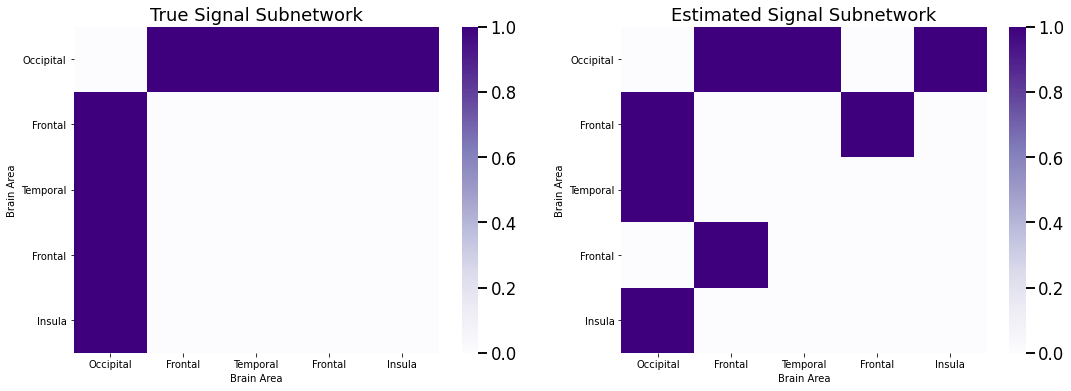

In [16]:
fig, axs = plt.subplots(1,2, figsize=(18, 6));
plot_prob(E, title="True Signal Subnetwork", ax=axs[0])
plot_prob(sigsub, title="Estimated Signal Subnetwork", ax=axs[1])

So our estimated signal subnetwork looks pretty close to the true signal subnetwork.

A question you might be wondering concerns how exactly we chose the number of signal edges to include in our estimate of the signal subnetwork, $\hat{\mathcal S}$. If we knew the number of edges in the signal subnetwork ahead of time, the choice would be easy: just choose $K$ to be the number of edges in the signal subnetwork! In real data, however, this isn't really going to be the case. For this reason, we will have to estimate $K$ using $\hat K$. To learn how to estimate $K$, we first need to learn how to put what we've covered so far into a classifier, so read on!

## Building a classifier using the estimated signal subnetwork

Finally, we can use the estimated signal subnetwork that we have constructed to devise a classifier. The objective of a classifier is to take new pieces of data (in this case, new networks), and assign them to the class which they are most likely from. How do we determine which class a network is most likely from?

At the moment, we have our estimate of the signal subnetwork, $\hat{\mathcal S}$, and have a bunch of networks from one of two classes: astronaut (class 1) or alien (class 2). The edges of the network are binary, and we want to use the edges which are in the signal subnetwork to classify points as either astronaut or alien. A natural classifier choice for this situation is known as the Naive Bayes classifier. We have all the ingredients we need to construct the Naive Bayes classifier, so we'll try to put this together. Feel free to skip past this next section if you want to jump right into the implementation of the classifier. In this next section, we will explain some of the intuition of the Naive Bayes classifer, which might require a bit of a probability and statistics background.

### Bayes Plugin Classifier (Statistical Intuition)

The core idea of the Naive Bayes classifier is, if our data have features which are zeros and ones, we can use the *class-conditional probabilities* to determine whether a point is from class $1$ or class $2$. The idea is as follows. First, we assume that all of the individual features of our data (the features, in our case, are the edges of the network that are in the signal subnetwork) are independent, then the likelihood of observing a particular sequence of edges in the signal subnetwork of the $m^{th}$ network if that network is in class $y$ is as follows. First, we will just write down some simpler notation for the quantity we want:

\begin{align*}
    \mathbb P(\text{observing }A^{(m)}\text{ given we assume }\text{$m$ is in class $y$} \text{ where the signal subnetwork is $\mathcal S$}) = \mathbb P(A^{(m)} | y_m = y; \mathcal S)
\end{align*}

Nothing happened in this step just yet; we just made a smaller notation for the quantity on the left that we will use later on. In this next step, we use the fact that, if edges existing and not existing are independent, then the probability of observing a sequence of edges is the product of the probabilities of observing each individual edge. This is called an *independent edge assumption*. We proceed as follows:
\begin{align*}
    \mathbb P(A^{(m)}| y_m = y; \mathcal S) &= \prod_{(i,j) \in \mathcal S} \mathbb P(a_{ij}^{(m)} | y_m = y; \mathcal S)
\end{align*}
Note that we are taking the product of each pair of edges, $(i,j)$, which are in the signal sub-network. Next, if we remember back to the Independent-Edge Random Network (IER), we assumed that if $\mathbf A^{(m)}$ was an $IER_n(P^y)$ network, that every edge $\mathbf a_{ij}^{(m)}$ had a probability of $p^y_{ij}$ of taking a value of $1$ (the edge exists), and a probability of $1 - p_{ij}^y$ of taking a value of $0$ (the edge does not exist). What this means is that $\mathbf a_{ij}^{(m)}$ is something called a **Bernoulli distributed random variable**. The probability of seeing a particular realization $a_{ij}^{(m)}$ of a Bernoulli distributed random variable is relatively straightforward to see. We want the quantity $\mathbb P(A^{(m)} | y_m = y; \mathcal S)$ to reflect the following two facts we've already discussed:
1. If $a_{ij}^{(m)}$ is $1$, then $\mathbb P(A^{(m)} | \mathbf y_m = y; \mathcal S)$ is $p_{ij}^y$.
2. If $a_{ij}^{(m)}$ is $0$, then $\mathbb P(A^{(m)} | \mathbf y_m = y; \mathcal S)$ is $1 - p_{ij}^y$.
Is there a succinct expression that we can express this with? Yes! Try the following equation:
\begin{align*}
    \mathbb P(A^{(m)} | \mathbf y_m = y; \mathcal S) &= (p_{ij}^y)^{a_{ij}^{(m)}} (1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}
\end{align*}
Notice that if $a_{ij}^{(m)}$ is $1$, then $1 - a_{ij}^{(m)}$ is $0$. Therefore, $(1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}$ is just $1$, since any number raised to the $0$ power is $1$. On the other hand, $(p_{ij}^y)^{a_{ij}^{(m)}}$ is $p_{ij}^y$, since any number raised to the $1$ power is itself. Therefore, this expression fits the bill for us. So, we can simplify our expression as:
\begin{align*}
\mathbb P(A^{(m)} | y_m = y; \mathcal S) &= \prod_{(i,j) \in \mathcal S} (p_{ij}^y)^{a_{ij}^{(m)}} (1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}
\end{align*}
And we're almost there! The next thing we're going to do is a little tricky, but fortunately we can turn to Bayes' Theorem for help. What we want to do is compute the probability of observing *both* $A^{(m)}$ *and* $y_m$ having the value $y$, not the probability of observing $A^{(m)}$ given that we assume that $y_m$ is $y$. In statistical notation, what this amounts to is:
\begin{align*}
    \mathbb P(\text{observing }A^{(m)}\text{ and }\text{$m$ is in class $y$} \text{ where the signal subnetwork is $\mathcal S$}) = \mathbb P(A^{(m)}, y_m = y; \mathcal S)
\end{align*}
This expression is a little confusing, but its interpretation is relatively straightforward: it is the probability that we see both things happening at the same time (the random network $\mathbf A^{(m)}$ takes the value $A^{(m)}$ and the random class $\mathbf y_m$ has the value $y$) rather than just assume that the random class $\mathbf y_m$ already is $y$. We can compute this quantity by remembering [Bayes' Theorem](#link?):
\begin{align*}
     \mathbb P(A^{(m)} |  \mathbb y_m = y; \mathcal S) &= \frac{\mathbb P(A^{(m)}, \mathbb y_m = y; \mathcal S)}{\mathbb P(\mathbb y_m = y)}
\end{align*}
Note that this implies the following:
\begin{align*}
\mathbb P(A^{(m)}, \mathbb y_m = y; \mathcal S) &= \mathbb P(A^{(m)} | \mathbb y_m = y; \mathcal S)\mathbb P(\mathbb y_m = y)
\end{align*}
Plugging in the value we obtained above:
\begin{align*}
\mathbb P(A^{(m)}, \mathbb y_m = y; \mathcal S) &= \mathbb P(\mathbb y_m = y)\prod_{(i, j) \in \mathcal S} (p_{ij}^y)^{a_{ij}^{(m)}} (1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}
\end{align*}
Remember that the parameter of the signal subnetwork model, $\pi_y$, represented the probability of our $Y$-sided die landing on class $y$, and therefore was the probability that the random class $\mathbf y_m$ took the value $y$. Therefore, $\mathbb P(\mathbb y_m = y) = \pi_y$, since these two quantites represent the same thing! So:
\begin{align*}
\mathbb P(A^{(m)}, \mathbb y_m = y; \mathcal S) &= \pi_y \prod_{(i, j) \in \mathcal S} (p_{ij}^y)^{a_{ij}^{(m)}} (1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}
\end{align*}

Finally, we introduce a new quantity. This quantity is very similar to the above quantity we came across, but with some terms reversed:
\begin{align*}
    \mathbb P(\text{$m$ is in class $y$}\text{ given we observe }$A^{(m)}$ \text{ where the signal subnetwork is $\mathcal S$}) = \mathbb P(\mathbb y_m = y | A^{(m)}; \mathcal S)
\end{align*}
Remember that we saw that using Bayes Theorem, we can just rewrite this expression as:
\begin{align*}
\mathbb P(\mathbb y_m = y | A^{(m)}; \mathcal S) &= \frac{\mathbb P(A^{(m)}, \mathbb y_m = y; \mathcal S)}{\mathbb P(A^{(m)}; \mathcal S)}
\end{align*}
But using the expression we just obtained for $\mathbb P(A^{(m)}, \mathbb y_m = y; \mathcal S)$, we can write this down as:
\begin{align*}
\mathbb P(\mathbb y_m = y | A^{(m)}; \mathcal S) &= \frac{\pi_y \prod_{(i, j) \in \mathcal S} (p_{ij}^y)^{a_{ij}^{(m)}} (1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}}{\mathbb P(A^{(m)}; \mathcal S)}
\end{align*}
So, what this quantity tells us is the probability that item $m$ is in class $y$, given that we observe that item $m$ has the network $A^{(m)}$ with signal subnetwork $\mathcal S$! When we have a new piece of data, this is an excellent quantity to compute! The reason for this is that, if we see a new network and want to assign it to a class, we want to choose the class that we think is most reasonable, or most probable. Therefore, given a new network to classify, it is reasonable to just estimate the class of this new network to be the class which is most probable, which is:
\begin{align*}
    \hat y_m &= \text{argmax}_{y \in \left\{1, ..., Y\right\}}\mathbb P(\mathbb y_m = y | A^{(m)}; \mathcal S) \\
    &= \text{argmax}_{y \in \left\{1,..., Y\right\}}\frac{\pi_y \prod_{(i, j) \in \mathcal S} (p_{ij}^y)^{a_{ij}^{(m)}} (1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}}{\mathbb P(A^{(m)}; \mathcal S)}
\end{align*}
What this states in words is, we check all possible values that $y$ could take (1, 2, 3, ... all the way to $Y$), and compute the probability that the class is $y$ given the network we observed. Then, we just choose which of the values was most plausible, and return it for our prediction $\hat y_m$. But wait! We can simplify this expression even further. Note that the quantity $\mathbb P(A^{(m)}; \mathcal S)$ has *no* dependence on the particular class we are checking for a given value of $y$. This means that the denominator will be the same for all of the possible values of $y$, and therefore won't impact which of the $y$s is the actual maximum. Therefore, we can just drop this term entirely, giving us the quantity that will become the objective function for our classification task:
\begin{align*}
\hat y_m &= \text{argmax}_{y \in \left\{1,..., Y\right\}}\pi_y \prod_{(i, j) \in \mathcal S} (p_{ij}^y)^{a_{ij}^{(m)}} (1 - p_{ij}^y)^{1 - a_{ij}^{(m)}}
\end{align*}
Now what you might be wondering is, we don't know $\mathcal S$, the vector $\vec \pi$, nor the probability matrices $P_1,..., P_Y$. This is why this is called a "Bayes Plugin" classifier. What we do is we estimate the signal subnetwork $\mathcal S$ using the approach we outlined above to produce $\hat{\mathcal S}$, and then we use the class vector $\vec y$ that we observed to produce estimates of $\vec \pi$, where:
\begin{align*}
    \hat{\pi_y} &= \frac{M_y}{M}
\end{align*}
where $M$ is the total number of networks, and $M_y$ is the number of networks where $y_m = y$. Finally, we compute the estimated probability entries, using:
\begin{align*}
    \hat p_{ij}^y &= \frac{1}{M_y} \sum_{m : y_m = y} a_{ij}^{(m)}
\end{align*}
What this means is that, for each edge $(i,j)$ which is in the estimated signal subnetwork $\hat{\mathcal S}$, we look at the $m$s where the class $y_m$ is $y$, and then we just compute the fraction of the edges which exist across all of the $M_y$ networks where $y_m = y$. Finally, we estimate the class for our new network $A^{(m)}$ by just "plugging in" these values to the objective function:
\begin{align*}
    \hat y_m &= \text{argmax}_{y \in \left\{1,..., Y\right\}}\hat \pi_y \prod_{(i, j) \in \hat{\mathcal S}} (\hat p_{ij}^y)^{a_{ij}^{(m)}} (1 - \hat p_{ij}^y)^{1 - a_{ij}^{(m)}}
\end{align*}
which is the objective function for the Bayes Plugin classifier.

### Classification with Bayes Plugin Classifier

So, how do we actually use the estimated signal subnetwork $\hat{\mathcal S}$ to classify new points? Quite simply, we can just use sklearn's `BernoulliNB` from `sklearn`, which is the Naive Bayes classifier for data where the features take values of $0$ and $1$ (such as our network). We need to reorganize our data a little bit to get it into the format we want. Our estimated signal subnetwork $\hat{\mathcal S}$ is returned to us by `graspologic` in the format of a `[2 x K]` matrix, where $K$ is the number of edges in the signal subnetwork. The first row is the row index of the entry of the signal subnetwork, and the second row is the column index of the entry in the signal subnetwork. We need to coerce this into an `[M x K]` matrix which we will call $D$, where $M$ is the total number of networks, and $K$ is the number of edges in the signal subnetwork. Each entry of this matrix $d_{mk}$ represents the adjacency value of the $m^{th}$ individual for the $k^{th}$ element of the signal subnetwork:

In [29]:
data = As[sgest.sigsub_[0], sgest.sigsub_[1],:].T

Next, we create a Naive Bayes classifier, and fit the classifier using the class vector $\vec y$ for all of our samples:

In [31]:
from sklearn.naive_bayes import BernoulliNB

classifier = BernoulliNB()
# fit the classifier using the vector of classes for each sample
classifier.fit(data, yvec)

BernoulliNB()

Let's see how it does! We create $50$ new networks, which are astronauts or earthlings, and assess the performance using the classification accuracy:

In [42]:
Mtest = 100

# roll a 2-sided die 100 times, with probability 0.4 of landing on side 1 (astronaut) 
# and 0.6 of landing on side 2 (earthling)
np.random.seed(12345678)
class_countstest = np.random.multinomial(Mtest, pvals=[pi_ast, pi_hum])
print("Number of individuals who are astronauts: {:d}".format(class_counts[0]))
print("Number of individuals who are humans: {:d}".format(class_counts[1]))

# create class assignment vector, and randomly reshuffle class labels for each individual
yvectest = np.array([1 for i in range(0, class_countstest[0])] + [2 for i in range(0, class_countstest[1])])
np.random.seed(12345678)
np.random.shuffle(yvectest)

Astest = []
np.random.seed(1234)
for y in yvectest:
    # sample adjacency matrix for an individual of class y using the probability
    # matrix for that class
    Astest.append(ier(prob_mtxs[y - 1], directed=False, loops=False))

# stack the adjacency matrices for each individual such that node i is first dimension,
# node j is second dimension, and the individual index m is the third dimension
Astest = np.stack(Astest, axis=2)

datatest = Astest[sgest.sigsub_[0], sgest.sigsub_[1],:].T

predictions = classifier.predict(datatest)

# classifier accuracy is the fraction of predictions that are correct
acc = np.mean(predictions == yvectest)
print("Classifier Accuracy: {:.3f}".format(acc))

Number of individuals who are astronauts: 40
Number of individuals who are humans: 60
Classifier Accuracy: 0.770


Which means our classifier is right about $77\%$ of the time. Not bad!